# NeuralODE
The proposed approach below is based on NeuralODE [[Chen et al, 2018](#1)].
Neural Network is presented as ODE. During training ODE is solved 

In [5]:
import sys ; sys.path.append('../')
from torchdyn.models import *
from torchdyn.datasets import *
from torchdyn import *

import pickle
import matplotlib.pyplot as plt

In [6]:
with open('data.pickle', 'rb') as f:
    D = pickle.load(f)

In [7]:
sp = 10
y_test = np.array([D['xs'], D['ys'], D['zs']]).T
x_test = D['t'][..., None]
y_train = y_test[::sp, 0]
x_train = x_test[::sp]

In [8]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
X_train = torch.Tensor(x_train).to(device)
Y_train = torch.Tensor(y_train).to(device)
train = data.TensorDataset(X_train, Y_train)
trainloader = data.DataLoader(train, batch_size=128, shuffle=True)

In [10]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = nn.MSELoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def train_dataloader(self):
        return trainloader

Analogously to most forward neural models we want to realize a map 

$$
        x \mapsto \hat y
$$

where  $\hat y$ becomes the best approximation of a true output $y$ given an input $x$.
In torchdyn you can define very simple Neural ODE models of the form 

$$ \left\{
    \begin{aligned}
        \dot{z}(s) &= f(z(s), \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad s\in[0,1]
$$

by just specifying a neural network $f$ and giving some simple settings.

**Note:** This Neural ODE model is of *depth-invariant* type as neither $f$ explicitly depend on $s$ nor the parameters $\theta$ are depth-varying. Together with their *depth-variant* counterpart with $s$ concatenated in the vector field was first proposed and implemented by [[Chen T. Q. et al, 2018]](https://arxiv.org/abs/1806.07366)

### Define the vector field (DEFunc) 

The first step is to define any PyTorch `torch.nn.Module`. This takes the role of the Neural ODE vector field $f(h,\theta)$ 

In [11]:
f = nn.Sequential(
        nn.Linear(1, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 1)                       
    )

In [12]:
model = NeuralDE(f, sensitivity='adjoint', solver='dopri5').to(device)

In [13]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=300)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 20 K  


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [14]:
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

Text(0.5, 1.0, 'Dimension 0')

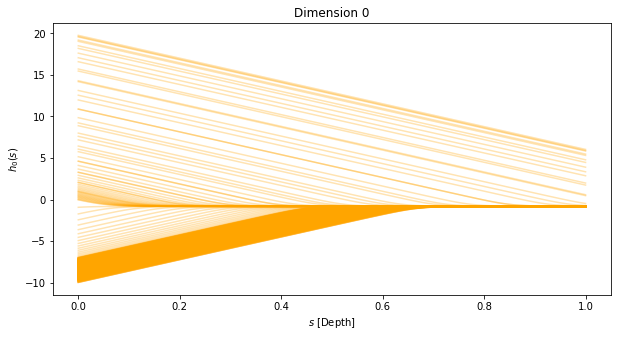

In [19]:
color=['orange', 'blue']

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(111)
for i in range(500):
    ax0.plot(s_span, trajectory[:,i,0], c='orange', alpha=.3)
ax0.set_xlabel(r"$s$ [Depth]")
ax0.set_ylabel(r"$h_0(s)$")
ax0.set_title("Dimension 0")

In [21]:
# evaluate vector field
# n_pts = 50
# x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
# y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
# X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
# f = model.defunc(0,z.to(device)).cpu().detach()
# fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# # plot vector field and its intensity
# fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
# ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
# ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')

<a id="ref"></a> 

# References
1. [Chen, R. T., Rubanova, Y., Bettencourt, J., & Duvenaud, D. K. (2018)](https://papers.nips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf). Neural ordinary differential equations. In Advances in neural information processing systems (pp. 6571-6583).
2. [Poli, M., Massaroli, S., Yamashita, A., Asama, H., & Park, J. (2020)](https://arxiv.org/pdf/2009.09346.pdf). Torchdyn: A neural differential equations library. arXiv preprint arXiv:2009.09346.